In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress

from datetime import datetime
from dateutil.parser import parse

import math
import os
import copy
import pickle

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Import data

In [3]:
file = open('drug_df_prices', 'rb')
drug_df = pickle.load(file)
file.close()

## Plot number of transactions/vendors over time

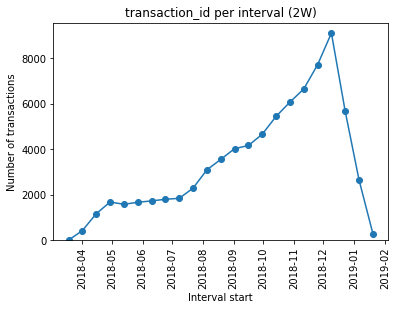

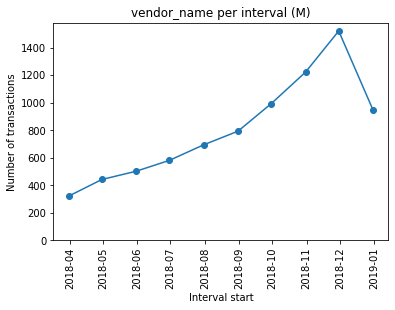

In [4]:
# Function plots number of transactions per time period given specified time interval length and feature
def plotFeatureOverTime(interval_code, feature):
    unique_per_interval = drug_df.resample(interval_code, on = 'date', label = 'left').nunique()[feature]
    plt.plot_date(unique_per_interval.index, unique_per_interval, ls = '-')
    plt.xticks(rotation='vertical')
    plt.ylim(bottom = 0)
    plt.title(feature +' per interval (' + interval_code + ')')
    plt.xlabel('Interval start')
    plt.ylabel('Number of transactions')
    plt.show()
    
# Plot results
plotFeatureOverTime('2W', 'transaction_id')
plotFeatureOverTime('M', 'vendor_name')

## Plot the following:
- number of vendors selling per drug for each time period
- number of transactions per drug for each time period
- revenue per drug for each time period

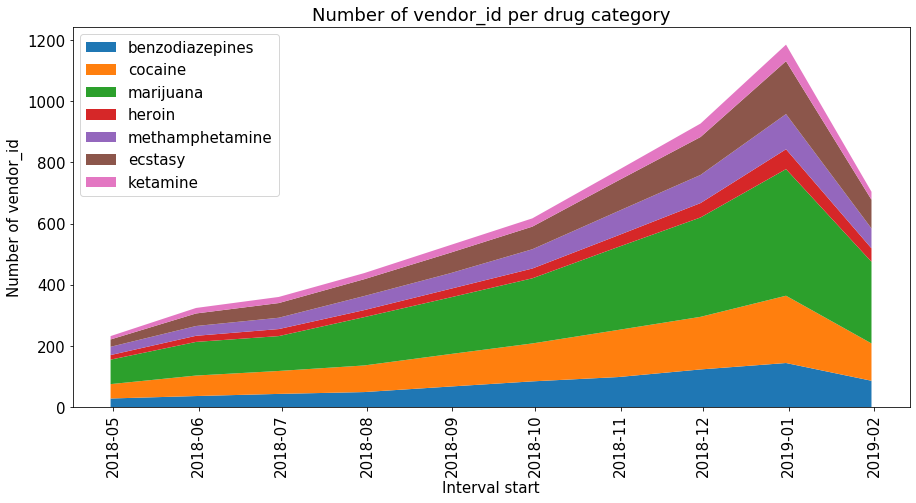

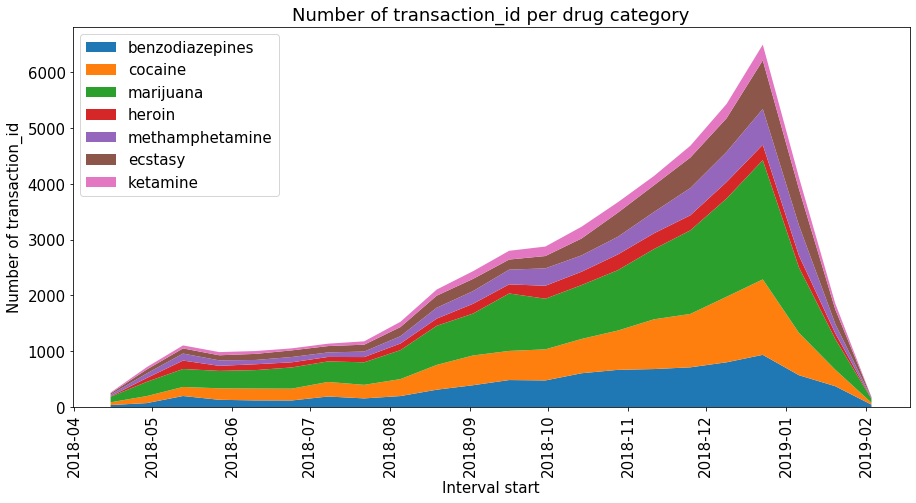

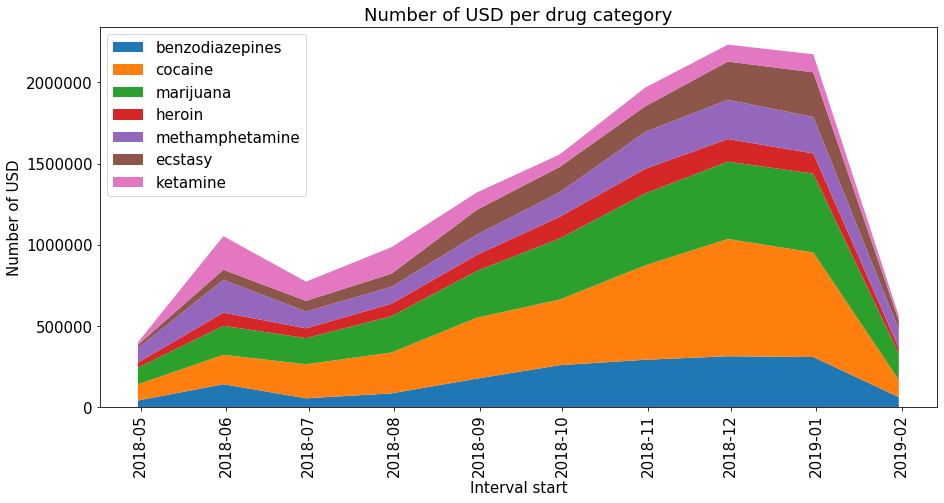

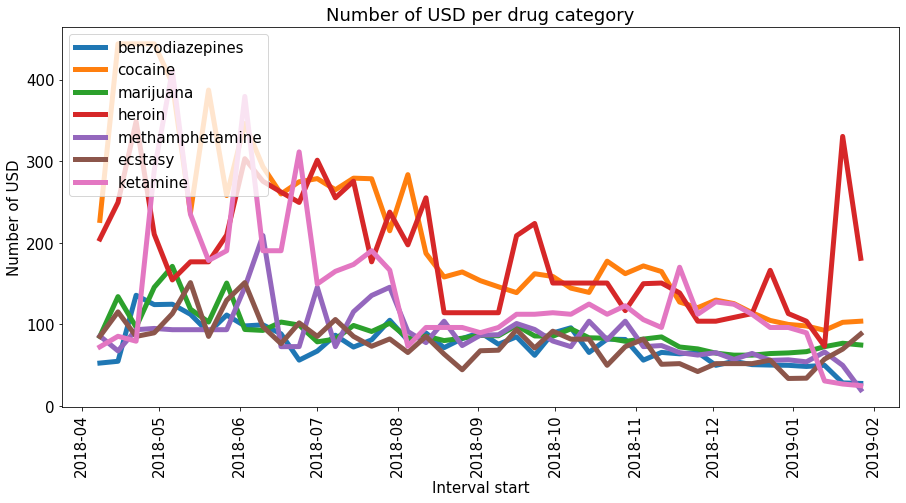

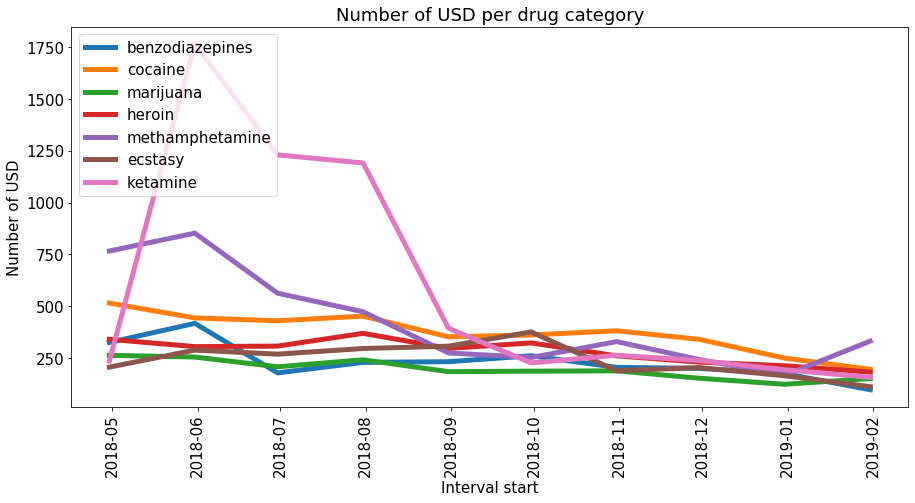

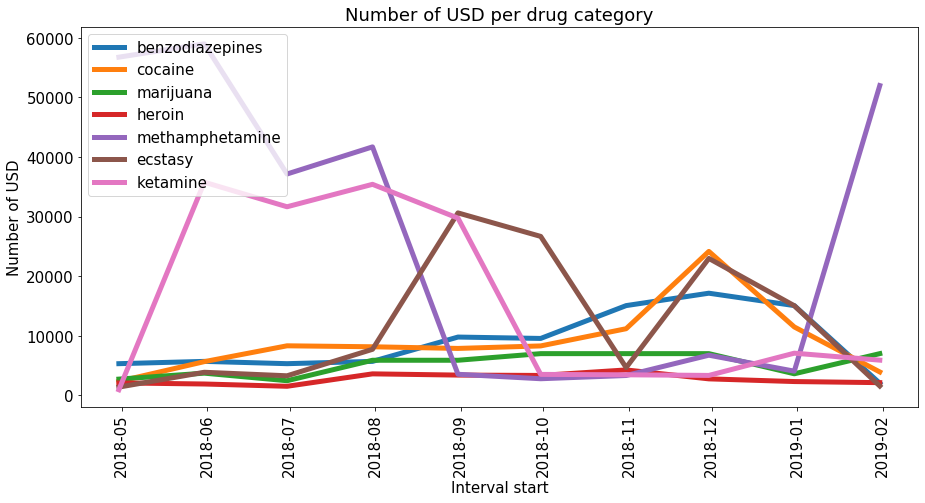

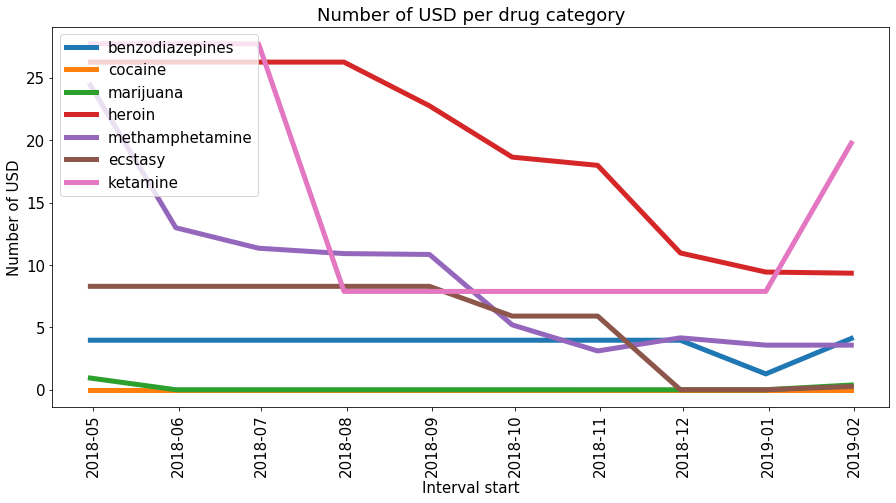

In [183]:
drug_subset = ['benzodiazepines', 'cocaine', 'marijuana', 'heroin', 'methamphetamine', 'ecstasy', 'ketamine']

# Get proportion of NA values
np.sum(drug_df.price_per_gram.isnull()) / drug_df.shape[0]

# Drop rows with NA value in price per gram column
drug_df_nonas = drug_df.dropna(axis = 'index', subset = ['price_per_gram'])

# Function to plot the number of features per drug category over time
def plotFeaturePerDrugOverTime(interval_code, feature, df = drug_df, make_stackplot = False, func = None):
    plt.rcParams.update({'font.size': 15})
    
    if func is None: 
        feature_per_drug = df.groupby(['drug_prediction', 
                                            pd.Grouper(key='date', freq=interval_code)])[feature].nunique()
    else:
        feature_per_drug = df.groupby(['drug_prediction', 
                                            pd.Grouper(key='date', freq=interval_code)])[feature].apply(func)
    
    plt.figure(figsize = (15,7))
    if make_stackplot:
        idx = feature_per_drug[drug_subset[0]].index
        y = [feature_per_drug[drug] for drug in drug_subset]
        plt.stackplot(idx, y, labels = drug_subset)
    else:    
        for drug in drug_subset:
            plt.plot(feature_per_drug[drug].index, feature_per_drug[drug], ls = '-', lw = 5)
    plt.legend(drug_subset, loc = 'upper left')
    plt.title('Number of '+ feature +' per drug category')
    plt.xlabel('Interval start')
    plt.ylabel('Number of ' + feature)
    plt.xticks(rotation='vertical')
    plt.show()
    
# Plot results
plotFeaturePerDrugOverTime('M', 'vendor_id', make_stackplot = True)
plotFeaturePerDrugOverTime('2W', 'transaction_id', make_stackplot = True)
plotFeaturePerDrugOverTime('M', 'USD', make_stackplot = True, func = np.sum)

plotFeaturePerDrugOverTime('W', 'USD', func = np.median)
plotFeaturePerDrugOverTime('M', 'USD', func = np.mean)
plotFeaturePerDrugOverTime('M', 'USD', func = np.max)
plotFeaturePerDrugOverTime('M', 'USD', func = np.min)

# plotFeaturePerDrugOverTime('M', 'price_per_gram', df = drug_df_nonas, func = np.max)

## Plot relative proportion of drugs/vendors over time

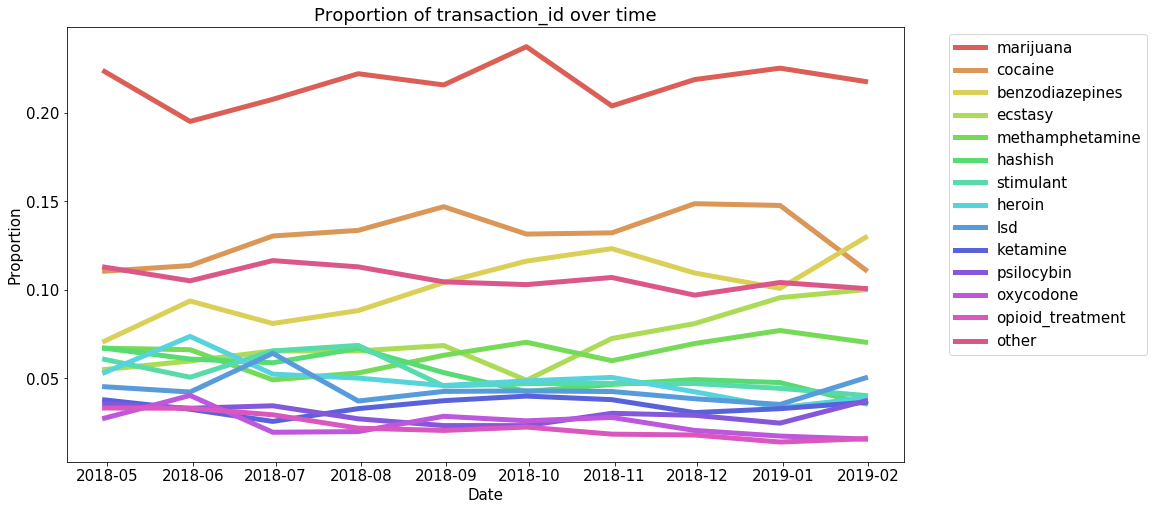

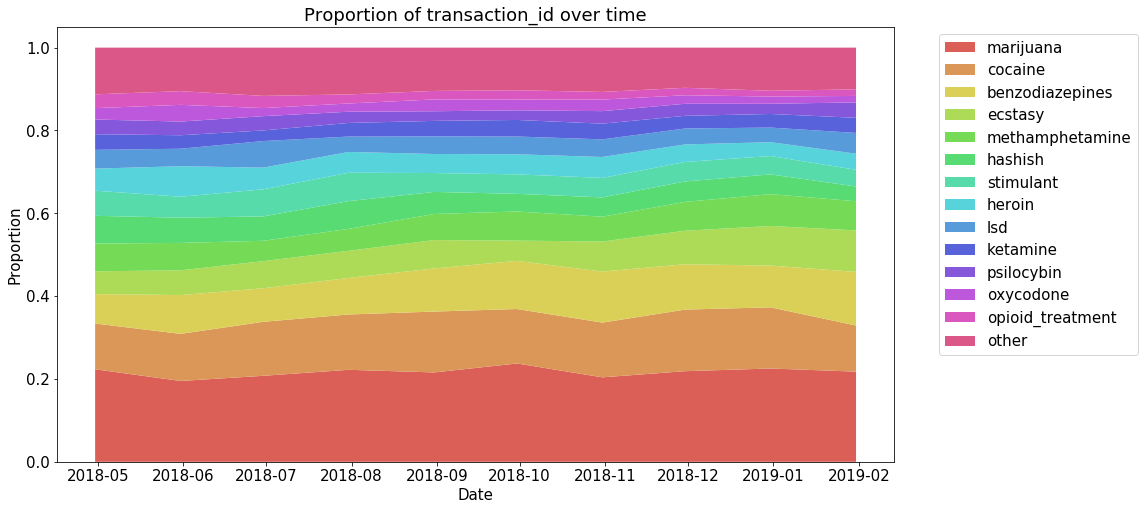

In [384]:
drug_subset = ['benzodiazepines', 'cocaine', 'marijuana', 'heroin', 'methamphetamine', 'ecstasy', 'ketamine']
drug_subset = pd.unique(drug_df.drug_prediction)

interval_code = 'M' # Time interval to use
feature = 'transaction_id' # Feature to look at

# compute statistics for each drug
feature_per_drug = drug_df.groupby(['drug_prediction', 
    pd.Grouper(key='date', freq=interval_code)])[feature].nunique()
# feature_per_drug = drug_df.groupby(['drug_prediction', pd.Grouper(key='date', freq=interval_code)])[feature].sum()

# compute overall statistics for time period
interval_stats = drug_df.groupby(pd.Grouper(key='date', freq=interval_code))[feature].nunique()
# interval_stats = drug_df.groupby(pd.Grouper(key='date', freq=interval_code))[feature].sum()

# join the two dataframes together
feature_per_drug = feature_per_drug.to_frame().join(interval_stats, on = 'date', rsuffix = '_total')
feature_per_drug.columns = [feature+'_for_drug', 'total_'+feature+'_count'] # Rename columns

# Compute proportion of total feature
feature_per_drug['proportion'] = feature_per_drug[feature+'_for_drug'] / feature_per_drug['total_'+feature+'_count']

# Rearrange results for stack-plotting
first_drug = drug_subset[0]
df = feature_per_drug.loc[first_drug,'proportion'].to_frame()
for drug in drug_subset[1:]:
        df = df.join(feature_per_drug.loc[drug, 'proportion'], on = 'date', rsuffix = '_'+drug)
df.columns = drug_subset

# Reorder the columns so that drug columns are in decreasing order (according to mean value of each column)
mean_vals = df.mean().sort_values(ascending = False)

# Remove drugs below a given threshold (replace with 'other')
other_thresh = .02
new_order = list(mean_vals[mean_vals > other_thresh].index)

# Update columns
df = df[new_order]
df = df.fillna(0) # Fill any NaN values with 0

# Add 'other' column to represent drugs below threshold
other = 1 - df.sum(axis = 1)
df = df.join(other.rename('other'), on = 'date')
new_order.append('other')

# Set color palette
import seaborn as sns
sns.set_palette(sns.color_palette("hls", len(new_order)))

# Line graph
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (15,8))
plt.plot(df.index, np.array(df), lw = 5)
plt.legend(new_order, bbox_to_anchor=(1.3, 1))
plt.title('Proportion of '+ feature+' over time')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.show()

# Stack plot
plt.figure(figsize = (15,8))
plt.stackplot(df.index, np.array(df).transpose())
plt.legend(new_order, bbox_to_anchor=(1.3, 1))
plt.title('Proportion of '+ feature+' over time')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.savefig('hello.png', dpi=500)
plt.show()

## Plot Gini index over time

In [6]:
# Function to get Gini index
def getGini(x):
#     Function to compute the Gini index of a sequence ordered in increasing order (technically non-decreasing order)
    numerator_sum = 0 # initialize numerator
    n = len(x) # number of elements in sequence
    mu = np.mean(x) # mean of sequence
    mu += .00000000001 # ensure not dividing by zero
    
    # Compute sum of numerator
    for i, x_i in enumerate(x):
        numerator_sum += (2*(i+1) - n - 1) * x_i
        
    # Divide numerator by denominator
    G = numerator_sum / (n**2 * mu)
    return(G)

# Function to get Gini index of unordered series
def giniWrapper(seq):
    ascending_vals = list(seq.sort_values())
    return(getGini(ascending_vals))

# Get cumulative sums of a list
def getCumSums(x):
    return [np.sum(x[:i+1]) for i in range(len(x))]

# Function to get Lorenz curves/ Gini indices for multiple drugs
def getDrugConcentration(drugs):
    vendor_list = pd.unique(drug_df['vendor_name'])
    
    # Get revenue for each vendor
    vendor_revenues = {drug : \
                       [getVendorRevenue_for_drug(vendor,drug) for vendor in vendor_list]\
                       for drug in drugs}

    # Sort revenues in descending order (for plotting) and for ascending order (for Gini)
    descending_revenues = {drug : sorted(vendor_revenues[drug], reverse = True) for drug in drugs}
    
    return(descending_revenues)

    
# Function creates Lorenz curves and computes Gini index given dictionary of descending revenues    
def getConcentrationStats(descending_revenues):
    
    # Get list of drugs (keys to descending_revenues dictionary)
    drugs = list(descending_revenues)
    
    # Get ascending revenues
    ascending_revenues = {drug : descending_revenues[drug][::-1] for drug in drugs}
    
    # Get cumulative sum of series (for plotting)
    cumulative_sales = {drug : getCumSums(descending_revenues[drug]) for drug in drugs}
    cumulative_sales_normal = {drug : cumulative_sales[drug]/cumulative_sales[drug][-1] for drug in drugs}
    
    # Compute Gini index for each drug
    ginis = [getGini(ascending_revenues[drug]) for drug in drugs]

Compute Gini index for each drug over time

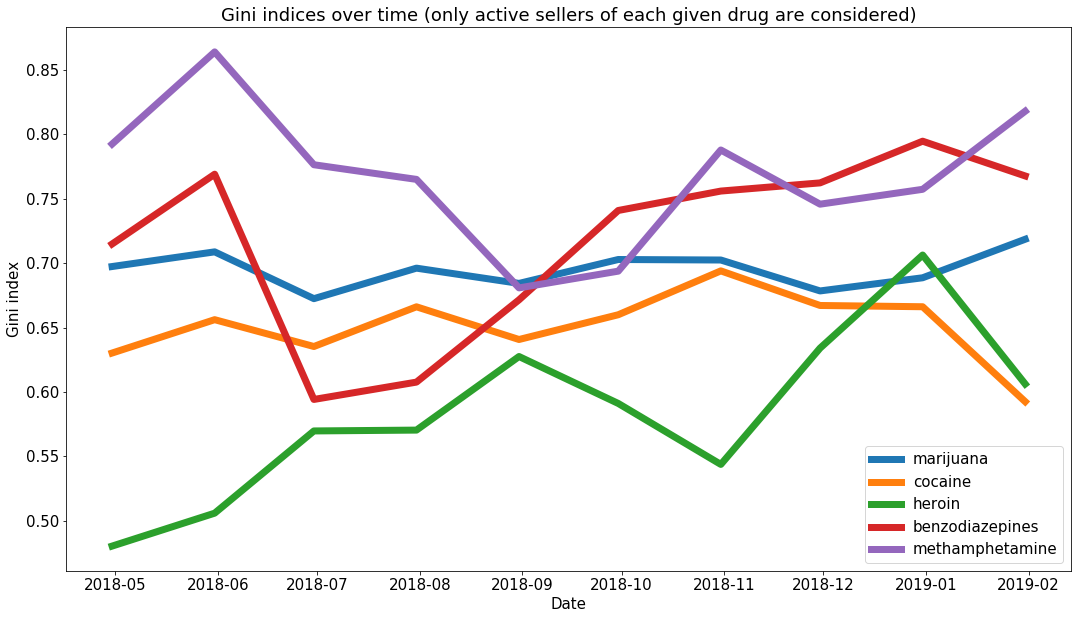

In [7]:
a = drug_df.groupby(['drug_prediction', pd.Grouper(key='date', freq='M'),'vendor_name'])
b = a.USD.sum()

# Get Gini index for each drug over time
drug_ginis_overtime = b.groupby(['drug_prediction', 'date']).apply(giniWrapper)

drug_subset_ginis = ['marijuana', 'cocaine', 'heroin', 'benzodiazepines', 'methamphetamine']
plt.figure(figsize = (18,10))
plt.rcParams.update({'font.size': 15})
for drug in drug_subset_ginis:
    plt.plot(drug_ginis_overtime[drug], lw = 7)
plt.legend(labels = drug_subset_ginis)
plt.title('Gini indices over time (only active sellers of each given drug are considered)')
plt.ylabel('Gini index')
plt.xlabel('Date')
plt.show()

Better method of computing Gini index for each drug (compare to all active vendors during given interval, rather than just the vendors sellign the given drug)

In [8]:
def getAscendingList(x, new_length):
#     Function takes a series and returns a list of items in the series sorted 
#     Also prepends a list of of zeros such that the total length is 'new_length'
    return(prependZeros(list(x.sort_values()), new_length))

def prependZeros(x, new_length):
#     Function prepends zeros to the list x to create a list of new_length
    n_zeros = new_length - len(x)
    zeros = [0 for _ in range(n_zeros)]
    return(zeros + x)


# Function takes in dataframe corresponding to one month of sales and outputs a dictionary of Gini indices for 
# each drug category
def getGiniFromDf(df):
    # Get unique drugs and vendors
    drugs = pd.unique(df.drug_prediction)
    vendors = pd.unique(df.vendor_name)

    # Group the data by drug_prediction and vendor_name
    a = df.groupby(['drug_prediction', 'vendor_name']).USD.sum()
    b = a.groupby(['drug_prediction']).apply(getAscendingList, new_length = len(vendors)).apply(getGini)
    return(b)

In [9]:
# Interval length to group dates by 
interval_length = 'M'

# Group reviews by date
grouped_by_date = drug_df.groupby(pd.Grouper(key = 'date', freq = interval_length))
# return dictionary for each drug?

# Now get list of gini indices for each drug, corresponding to each month
drug_ginis_over_time = grouped_by_date.apply(getGiniFromDf).groupby('drug_prediction').apply(lambda x : list(x))

Plot results (including overall Gini over time)

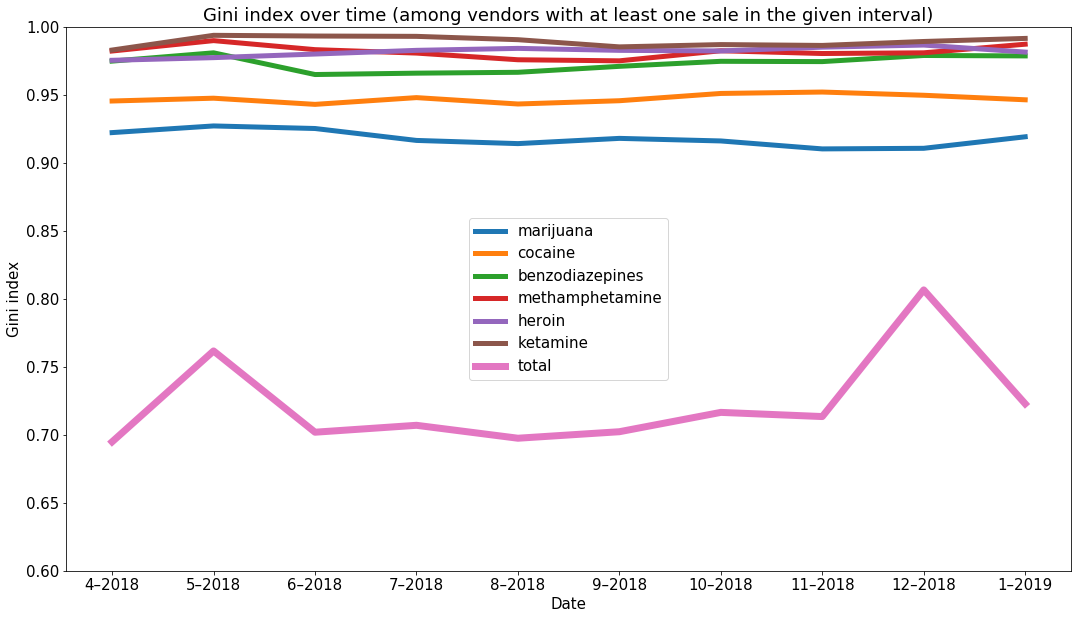

In [13]:
# First, compute overall Gini over time
a = drug_df.groupby([pd.Grouper(key='date', freq='M'),'vendor_name'])
b = a.USD.sum()

# Get Gini index for each drug over time
ginis_overtime = b.groupby(['date']).apply(giniWrapper)


# Plot results
plt.figure(figsize = (18,10))
plt.rcParams.update({'font.size': 15})
drugs = ['marijuana', 'cocaine', 'benzodiazepines', 'methamphetamine', 'heroin', 'ketamine']
# grouped_by_date.apply(getGiniFromDf)[datetime(2018,5,31)]['heroin']
for drug in drugs:
    plt.plot(drug_ginis_over_time[drug], lw = 5)
plt.plot(ginis_overtime.values, lw = 7)

# Append 'total' to drug list (for legend)
drugs.append('total')

# Set xlabels
xlabs = [str(each_date.month) + '–' + str(each_date.year) for each_date in ginis_overtime.index]
plt.xticks(np.arange(10), xlabs)
plt.title('Gini index over time (among vendors with at least one sale in the given interval)')
plt.ylabel('Gini index')
plt.legend(drugs)
plt.xlabel('Date')
plt.ylim(bottom = .6, top = 1)
plt.show()

## Plot number of vendors generating 50% of revenue for each drug category
Another idea: Weighted Gini: multiply gini for each drug by the number of vendors in that category

In [83]:
interval_length = '1W'

# Group dataframe by date and drug
date_drug_grouper = drug_df.groupby([pd.Grouper(key = 'date', freq = interval_length), 'drug_prediction'])

# Function takes in dataframe corresponding to one month of sales and outputs a dictionary of Gini indices for 
# each drug category
def getTop50Vendor_percent(df, thresh = .5, is_proportion = True):
    total_revenue = df.USD.sum() # Compute total revenue for drug during specified period
    vendor_revenues = df.groupby('vendor_name').USD.sum() # get revenue for each vendor during time period
    vendor_revenues = vendor_revenues.sort_values(ascending = False) # sort revenues in descending order
    cumulative_sales_prop = getCumSums(vendor_revenues) / total_revenue # get cumulative sums and divide by total
    
    idx = np.nonzero(cumulative_sales_prop > thresh)[0][0] # find first index of which is > thresh
    if is_proportion:
        return((idx + 1) / len(cumulative_sales_prop)) # get the proportion of vendors at or before this index
    else:
        return((idx + 1)) # get the number of vendors at or before this index

res = date_drug_grouper.apply(getTop50Vendor_percent)
res = res.unstack(level = 1)

# Compute total proportion across all drugs
total_res = drug_df.groupby(pd.Grouper(key = 'date', freq = interval_length)).apply(getTop50Vendor_percent)
res['Total'] = total_res

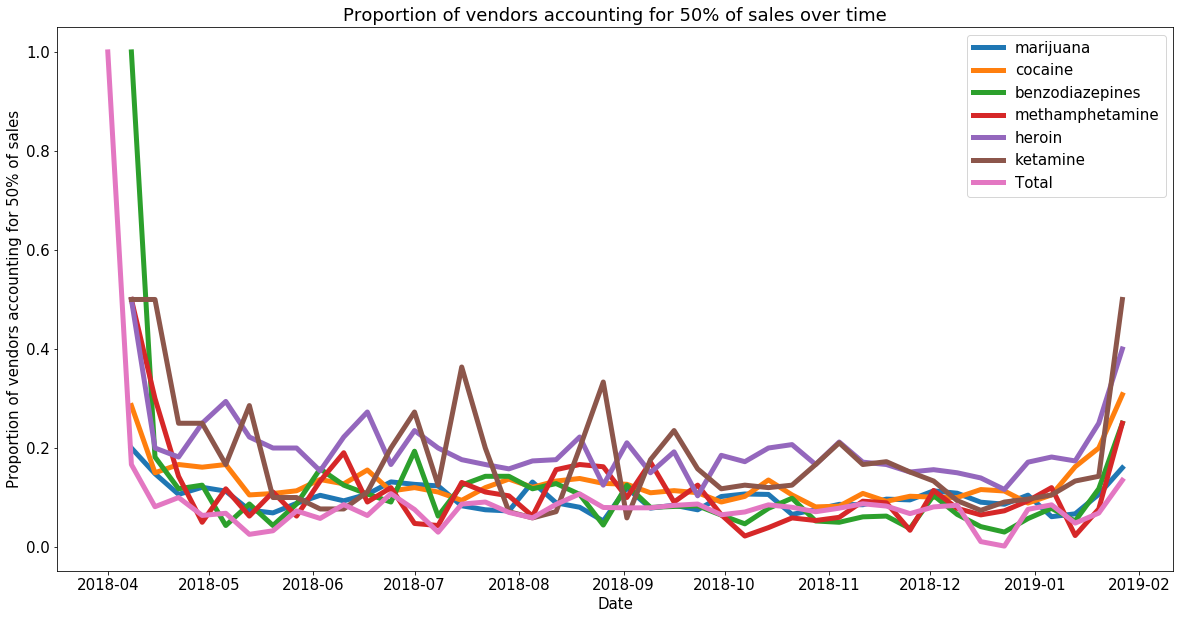

In [86]:
drugs = ['marijuana', 'cocaine', 'benzodiazepines', 'methamphetamine', 'heroin', 'ketamine','Total']
plt.figure(figsize = (20,10))
plt.plot(res.loc[:, drugs], lw = 5)
plt.legend(drugs)
plt.ylabel('Proportion of vendors accounting for 50% of sales')
plt.xlabel('Date')
plt.title('Proportion of vendors accounting for 50% of sales over time')
plt.show()

## Price over time

First, get median price over time

In [94]:
drug_df.head()

,transaction_id,vendor_id,vendor_name,bitcoin_amt,USD,EUR,product_description,date,drug_prediction,unit_mass,unit_mass_grams,count,total_mass,price_per_gram
9430,'10528,590,superclr,-1.0,416.000,-1.0,5 GRAMS GRADE AAA+ CARTEL TAN POWDER HEROIN,2018-11-02 06:43:01,heroin,5 g,5.000,NaN,5.0,83.200
9431,'10529,590,superclr,-1.0,416.000,-1.0,5 GRAMS GRADE AAA+ CARTEL TAN POWDER HEROIN,2018-11-10 06:43:01,heroin,5 g,5.000,NaN,5.0,83.200
9435,'10533,92,OnionKings,-1.0,109.119,-1.0,Rivotril 2mg från apotek (Roche) [100st],2018-12-21 06:43:11,benzodiazepines,2mg,0.002,100.0,0.2,545.595
9437,'10535,92,OnionKings,-1.0,109.119,-1.0,Rivotril 2mg från apotek (Roche) [100st],2018-12-22 06:43:11,benzodiazepines,2mg,0.002,100.0,0.2,545.595
9439,'10537,92,OnionKings,-1.0,109.119,-1.0,Rivotril 2mg från apotek (Roche) [100st],2018-12-01 06:43:11,benzodiazepines,2mg,0.002,100.0,0.2,545.595
